In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import re
import nltk
from tqdm import tqdm
import warnings
from wordcloud import WordCloud, STOPWORDS
import string
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from PIL import Image

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)


c1 = 'forestgreen'
c2 = 'dodgerblue'
c3 = 'tomato'

colors = [c1, c2, c3]

In [11]:


path = "/content/drive/MyDrive/endsars.json"

df = pd.read_json(path, lines = True)

#cols = ['date', 'time',  'username', 'name', 'place', 'tweet', 'mentions',  'replies_count', 'retweets_count', 'likes_count', 'hashtags']

#data = data[cols]

# For this analysis, we would only be using the text columns for analysis and username just for identification should there be a need for it

data = df[['username', 'tweet']]

data.head(3)

,username,tweet
0,nnamdi2much,Dear @CNN @cnni Are you going to allow @State...
1,ugochalacha,"Stop all this #EndSARS protests, protest to Di..."
2,badruabdulfatai,We are tired!!!!!!!! #HarassBuhariOutOfLondon ...


(130066, 2)


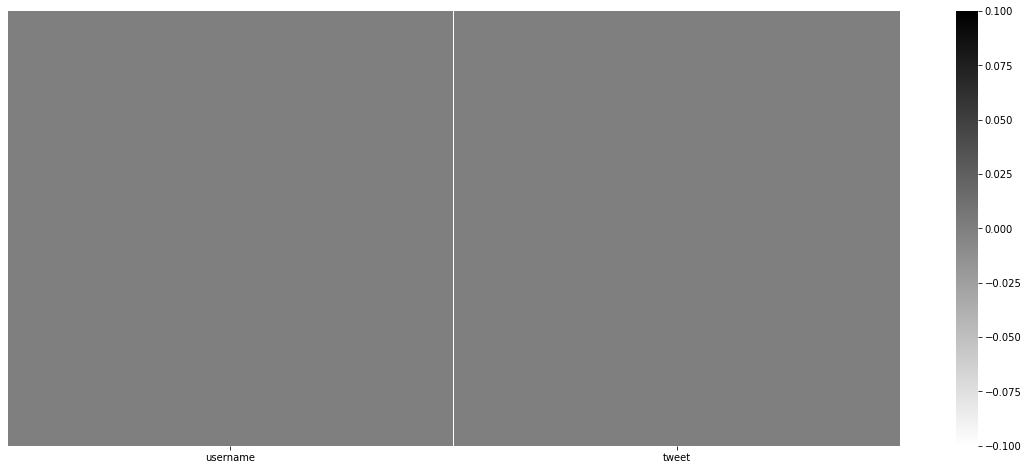

In [12]:
plt.figure(figsize = (20,8))
print(data.shape)
sns.heatmap(data.isna(), cmap = 'binary')
plt.yticks([]);

In [13]:
data.describe(include = 'all')

,username,tweet
count,130066,130066
unique,38770,96828
top,spotweefy,#EndSARS
freq,1386,3201


In [14]:
reg_pattern = {'hastags': "#(\w*)",
              'mentions': "@(\w*)",
              'urls': "https?://(?:[-\w./])+",
               "punc": "[^\w\s\d]",
              "multspace": "[\s]+"}


for pattern in tqdm(reg_pattern.values()):
    data['tweet'] = data['tweet'].apply(lambda x: re.sub(pattern, ' ', x))

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


In [ ]:
data.head(3)

,username,tweet
0,nnamdi2much,Dear Are you going to allow rubbish that brill...
1,ugochalacha,Stop all this protests protest to Divide Niger...
2,badruabdulfatai,We are tired


### Create Sentiment score using VADER

In [23]:
sid = SIA()

data['sentiment'] = data['tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])

# For the sake of the analysis, id also be using just two classes. i.e. No neutral ground...
data['sentiment'] = data['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

data.head(5)

,username,tweet,sentiment
0,nnamdi2much,Dear Are you going to allow rubbish that brill...,Positive
1,ugochalacha,Stop all this protests protest to Divide Niger...,Negative
2,badruabdulfatai,We are tired,Negative
3,monkof_god,Information travels so fast Different platform...,Positive
4,tommy63127717,Female Lhasa for sale 2 shots of vaccine taken...,Negative


In [18]:
# Just to see the first few tweets and how they have been transformed to provide their given sentiment

print('\n\n'.join(df.tweet[:5]))

Dear @CNN @cnni  Are you going to allow @StateDept rubbish that brilliant investigative report by @nimaelbagir on #EndSARS ?  Would you have allowed it under @Trump ?

Stop all this #EndSARS protests, protest to Divide Nigeria that is the only way to #EndSARS and Bad Leaderships in our regions.   #BiafranBoy

We are tired!!!!!!!! #HarassBuhariOutOfLondon #BuhariMustGo #EndSARS #BuhariTormentor

Information travels so fast. Different platforms publicised the success. It travels with an aeroplane; and here we are. LASU to the world! #Lasuleads #Lasuleads #EndSARS #Lasuleads

Female Lhasa for sale. 2 shots of vaccine taken. #HarassBuhariOutOfLondon USSD Mr P #WizkidXDavido INEC NIN-SIM Bella Nigerian Air Force Zidane #EndSARS ￼ #Ethereum Judas Laycon SWB Album  https://t.co/Yzw7Ia5KSh


In [19]:
print('\n\n'.join(data.tweet[:5]))
print()
print(data['sentiment'][:5])

Dear Are you going to allow rubbish that brilliant investigative report by on Would you have allowed it under 

Stop all this protests protest to Divide Nigeria that is the only way to and Bad Leaderships in our regions 

We are tired 

Information travels so fast Different platforms publicised the success It travels with an aeroplane and here we are LASU to the world 

Female Lhasa for sale 2 shots of vaccine taken USSD Mr P INEC NIN SIM Bella Nigerian Air Force Zidane Judas Laycon SWB Album 

0    1
1    0
2    0
3    1
4    0
Name: sentiment, dtype: int64


#### Insights on first 5 data


From the above data, we can begin to take a clue of our our data was analyzed to provide the given sentiment
- The negatively classfied tweets have words such as 'Stop', 'bad', 'are tired', 'shots', 'force'. These are likely to have contributed to the models decision
- The positively classified tweets have words like 'brilliant', 'success'

## N-grams Analysis

The N-gram analysis is a means of providing context to text tokens in order to provide some hidden insight in text analysis. It has found appliation in several text completion or recommendation softwares such as the ones we get to use when chatting with our phones on Whatsapp or while composing a mail on Gmail.

In [20]:
# Creating a pipeline of functions that would sort of automate the analysis to be done


def tokenize(df, sent = 'Positive'):
    temp_df = df[df['sentiment'] == sent]['tweet']
    
    corpus = ' '.join(text.lower() for text in temp_df)
    corpus = [i for i in corpus.split() if len(i) >= 3 and i not in STOPWORDS]
    return corpus

def get_grammy(df, ngram = 1, nfreq = 20, sent = "Positive"):
    corpus = tokenize(df, sent = sent)
    #corpus = 
    grammy = list(ngrams(corpus, ngram))
    counts = Counter(grammy)
    if nfreq == -1:
        freqs = counts.items()
    else:   
        freqs = counts.most_common(nfreq)
    gramdf = pd.DataFrame(columns = ['text', 'freq'])

    gramdf['text'] = [' '.join(word_dict[0]) for word_dict in freqs ]
    gramdf['freq'] = [word_dict[1] for word_dict in freqs ]
    gramdf.ngram = ngram
    gramdf.label = sent
    return gramdf

def display_grammy(datum):
    plt.style.use('fivethirtyeight')
    colors = [c1, c3]
    col = len(datum)
    fig, axes = plt.subplots(ncols=col, figsize = (25,12))
    for idx, temp_df in enumerate(datum):
        axes[idx].barh(temp_df['text'], temp_df['freq'], color = colors[idx])
        axes[idx].set_title(f"Top {len(temp_df)} most common {temp_df.ngram}-gram plot for {temp_df.label} tweets", fontsize = 16)


    plt.tight_layout()

    
def show_wordcloud(corpus, dpi = 50):

    im_path = r"C:\Users\iwaki\OneDrive\Documents\IQube Assessment\Ngrams\new.png"

    im_num = np.array(Image.open(im_path))

    new_mask = np.ndarray((im_num.shape[0], im_num.shape[1], im_num.shape[2]), np.int32)

    for i in range(len(im_num)):
        for j in range(len(im_num[i])):
            new_mask[i][j] = list(map((lambda x: 255 if x == 0 else 0), im_num[i][j]))

    wordcloud = WordCloud(width = 1500,
                         height = 500, background_color= 'white',
                         random_state= 42, mask = new_mask,
                         max_font_size=100).generate(' '.join(corpus))

    plt.figure(figsize = (16,7), dpi = dpi)
    plt.imshow(wordcloud, interpolation= 'bilinear')
    plt.axis('off')
    plt.show()

### Unigrams

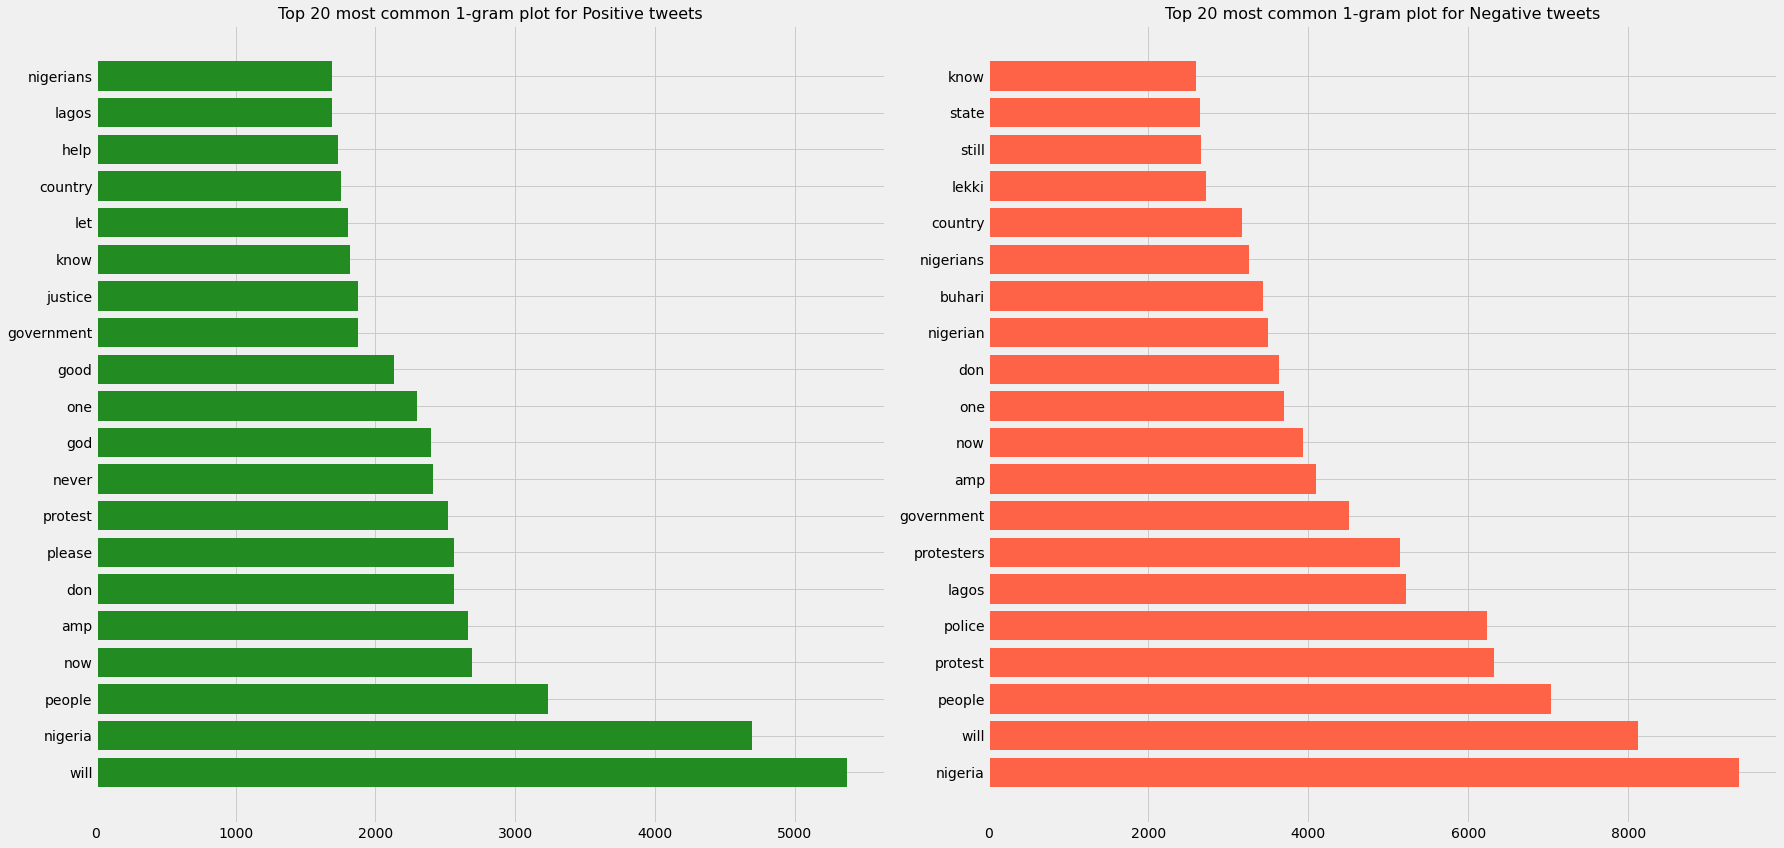

In [24]:
pos_df1 = get_grammy(data)
neg_df1 = get_grammy(data, sent = "Negative")
datum = [pos_df1, neg_df1]
display_grammy(datum)

#### Inferences

From the above we see trending topics or most commonly used word in or body of text. It can clearly be seen with almost no effort that some of these topics or words provide us with no knowledge stand-alone. And for that reason, we'd consider the othe ngram variants

### Bigram Analysis

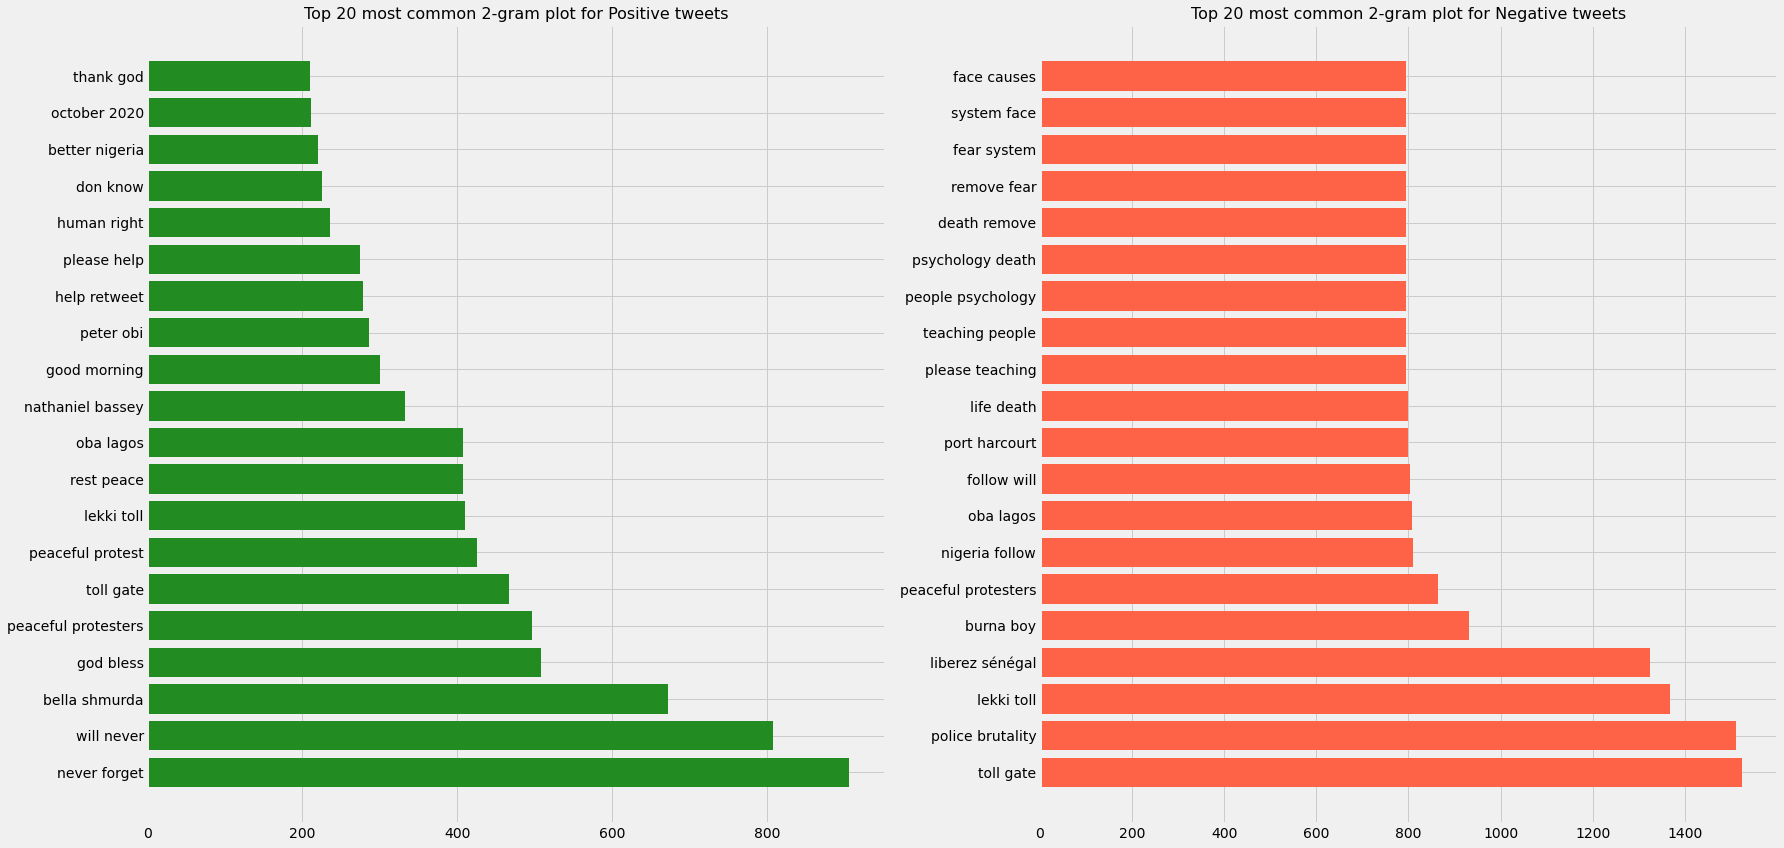

In [25]:
pos_df2 = get_grammy(data, ngram =2)
neg_df2 = get_grammy(data, ngram = 2, sent = 'Negative')

datum = [pos_df2, neg_df2]
display_grammy(datum)

#### Insights

From the above we can see improved insight into what exactly is being talked about in out text body. It makes more sense given the backround knowledge behind the data extracted from twitter. Several months after the __"peaceful protest"__ that was held in **"lekki toll"** + __"toll gate"__ sometime in __"October 2020"__ we see that some of these person choose to __"never forget"__ surrounding events around this date.
This clearly illustrate the power of insight Ngram brings to text analysis and preprocessing

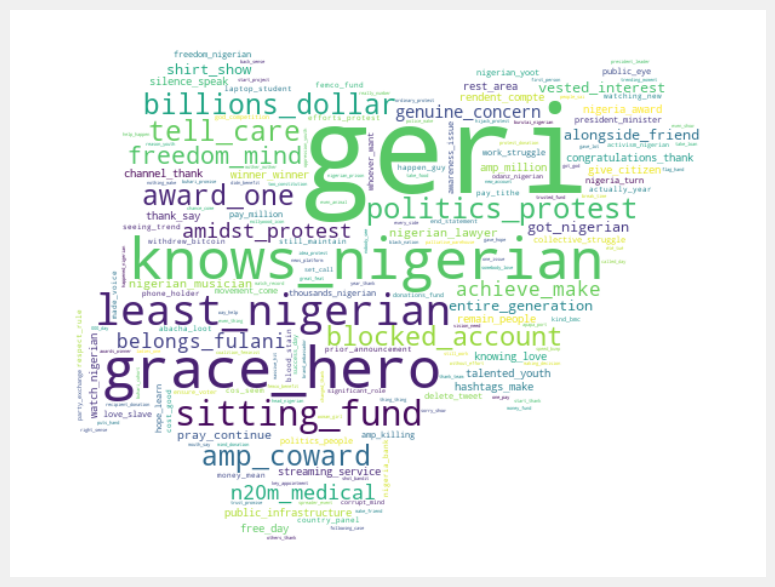

In [ ]:
# A wordcloud for bigrams of positively sentimented tweets

pos_token = tokenize(data)
pt_corpus = [i.replace(' ','_') for i,j in zip(pos_token['text'], pos_token['freq'])]

show_wordcloud(pt_corpus, dpi = 100)

### Trigram Ananlysis

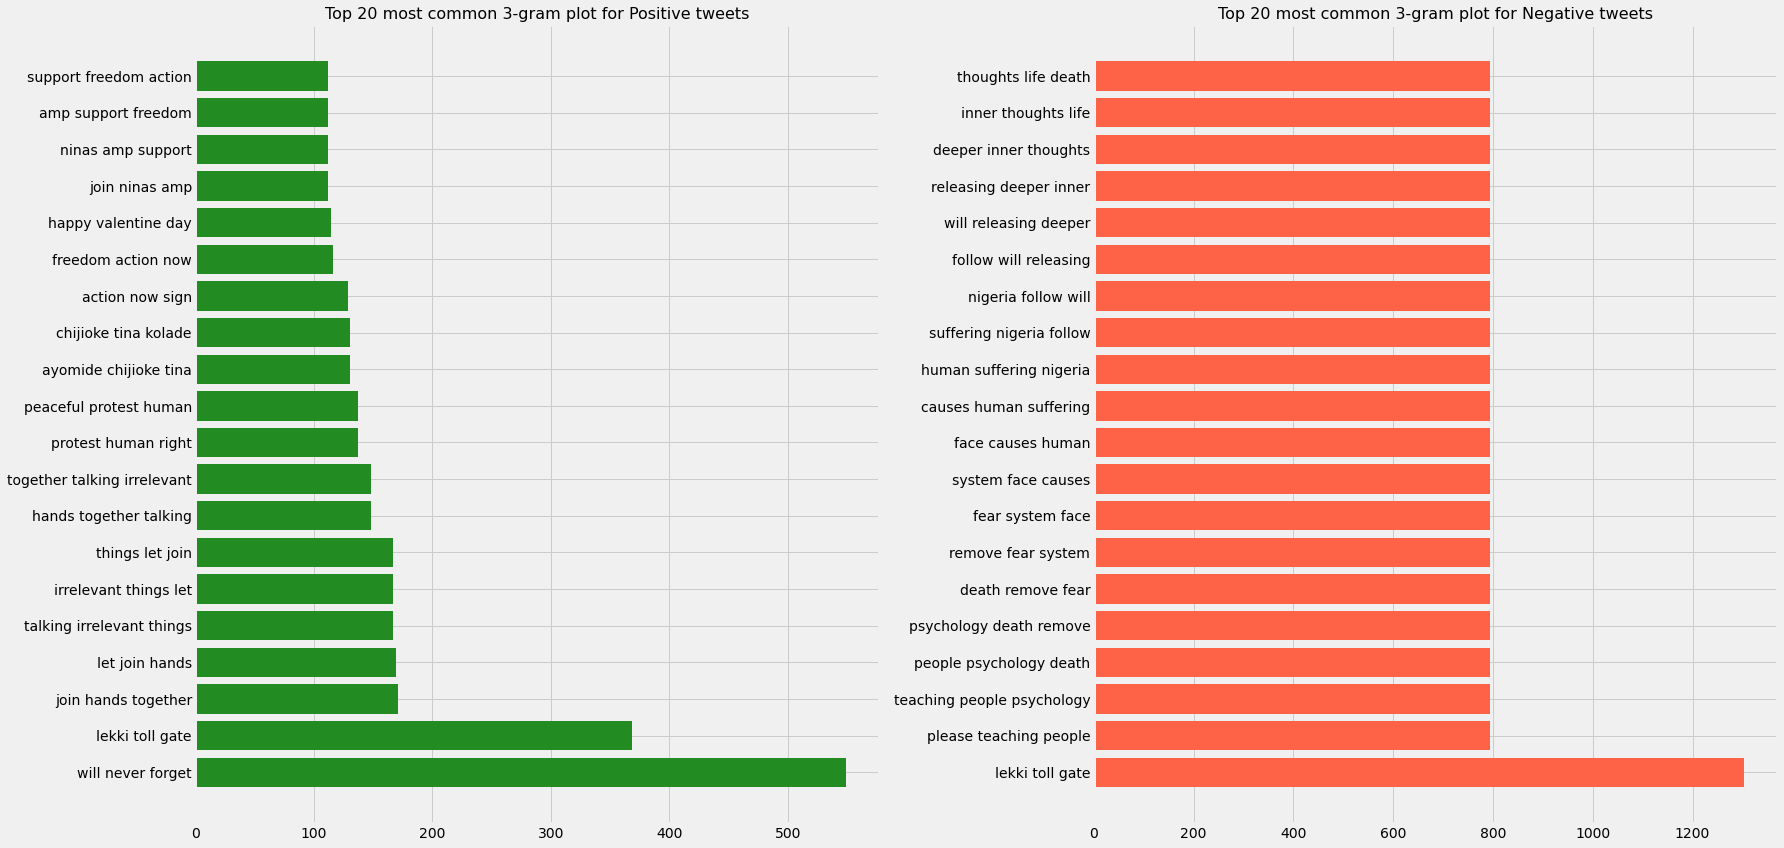

In [26]:
pos_df3 = get_grammy(data, ngram = 3)
neg_df3 = get_grammy(data, ngram = 3, sent = 'Negative')

datum = [pos_df3, neg_df3]
display_grammy(datum)

#### Inferences

Looking at the change in distiburion of frequency of phrases particularly of phrases in the Negatively segmented tweets. Could it be that words likely go out of context with increasing ngrams or could higher ngram values correlate to a need for higher data volume??!!!

### Quadgram

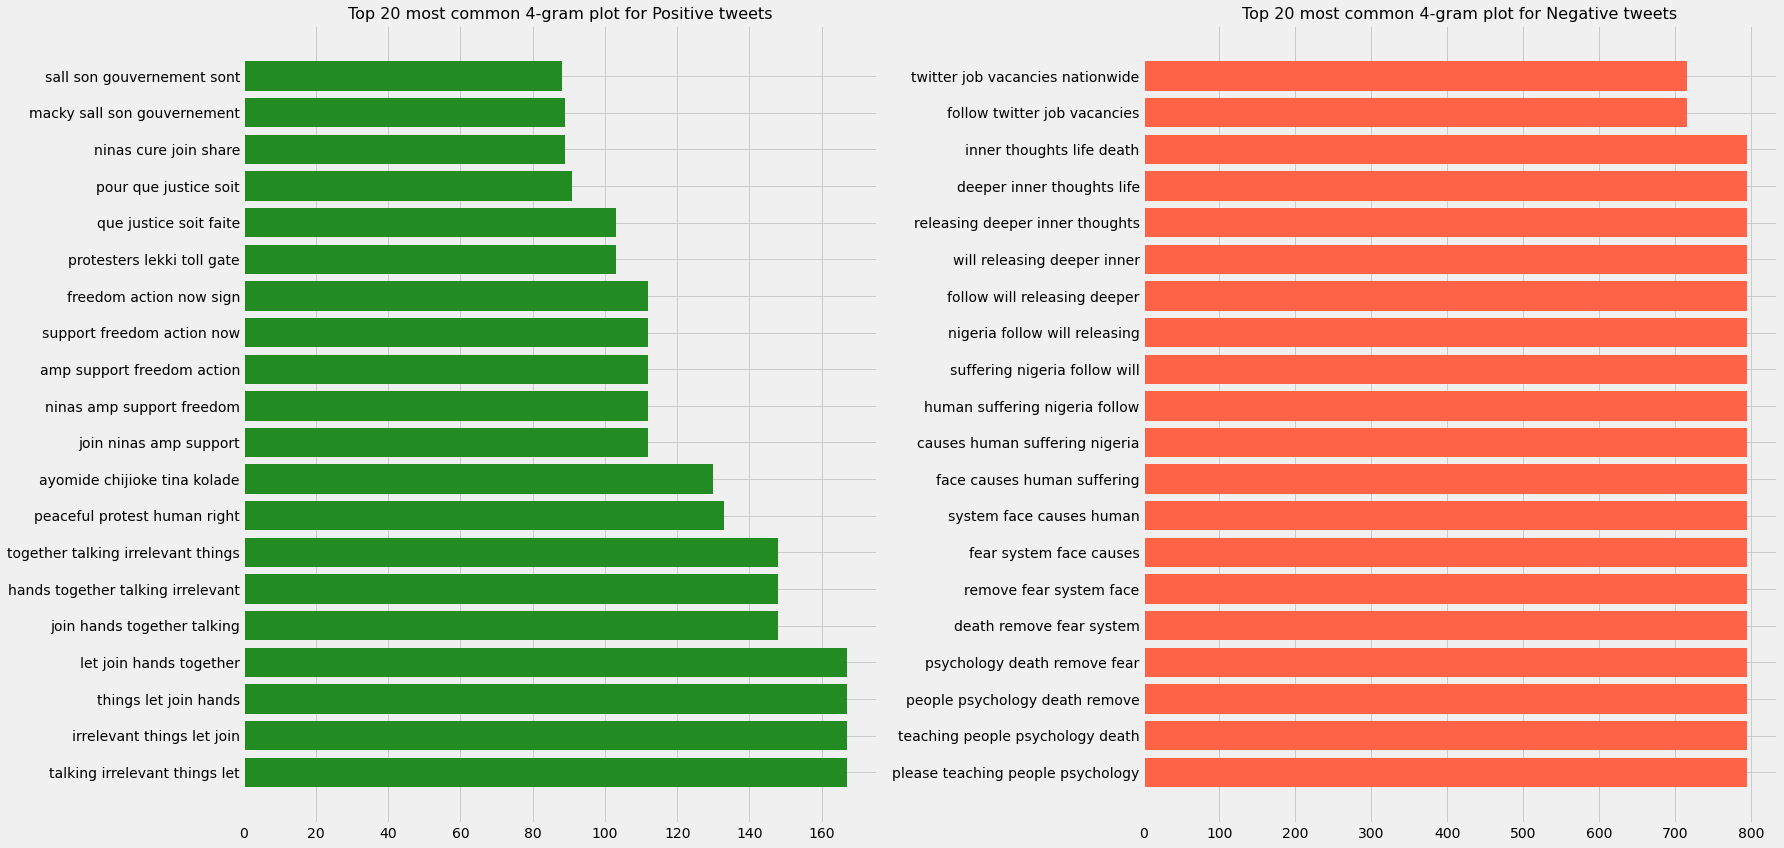

In [27]:
pos_df4 = get_grammy(data, ngram = 4)
neg_df4 = get_grammy(data, ngram = 4, sent = 'Negative')

datum = [pos_df4, neg_df4]
display_grammy(datum)